In [1]:
import os

In [2]:
os.environ['KAGGLE_USERNAME'] = 'xoos0420' # USERNAME
os.environ['KAGGLE_KEY'] = '3fcce1f3acb429935a009c08fb889557' # KEY

In [3]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip -q cat-and-dog

 99% 215M/218M [00:00<00:00, 288MB/s]
100% 218M/218M [00:00<00:00, 297MB/s]


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)), # 최대 10도까지 무작위로 변형, 이미지의 크기를 0.8 부터 1.2 사이의 비율로 조정
        transforms.RandomHorizontalFlip(), # 좌우 반전
        transforms.ToTensor(),
    ]),
    'validation' : transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [7]:
def target_transforms(target):
  return torch.FloatTensor([target])

In [21]:
image_datasets = {
    'train':datasets.ImageFolder('training_set/training_set', data_transforms['train'], target_transform=target_transforms),
    'validation':datasets.ImageFolder('test_set/test_set', data_transforms['validation'], target_transform=target_transforms)
}

dataloaders = {
    'train':DataLoader(
        image_datasets['train'],
        batch_size = 64,
        shuffle = True
    ),
    'validation':DataLoader(
        image_datasets['validation'],
        batch_size = 64,
        shuffle = False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

8005 2023


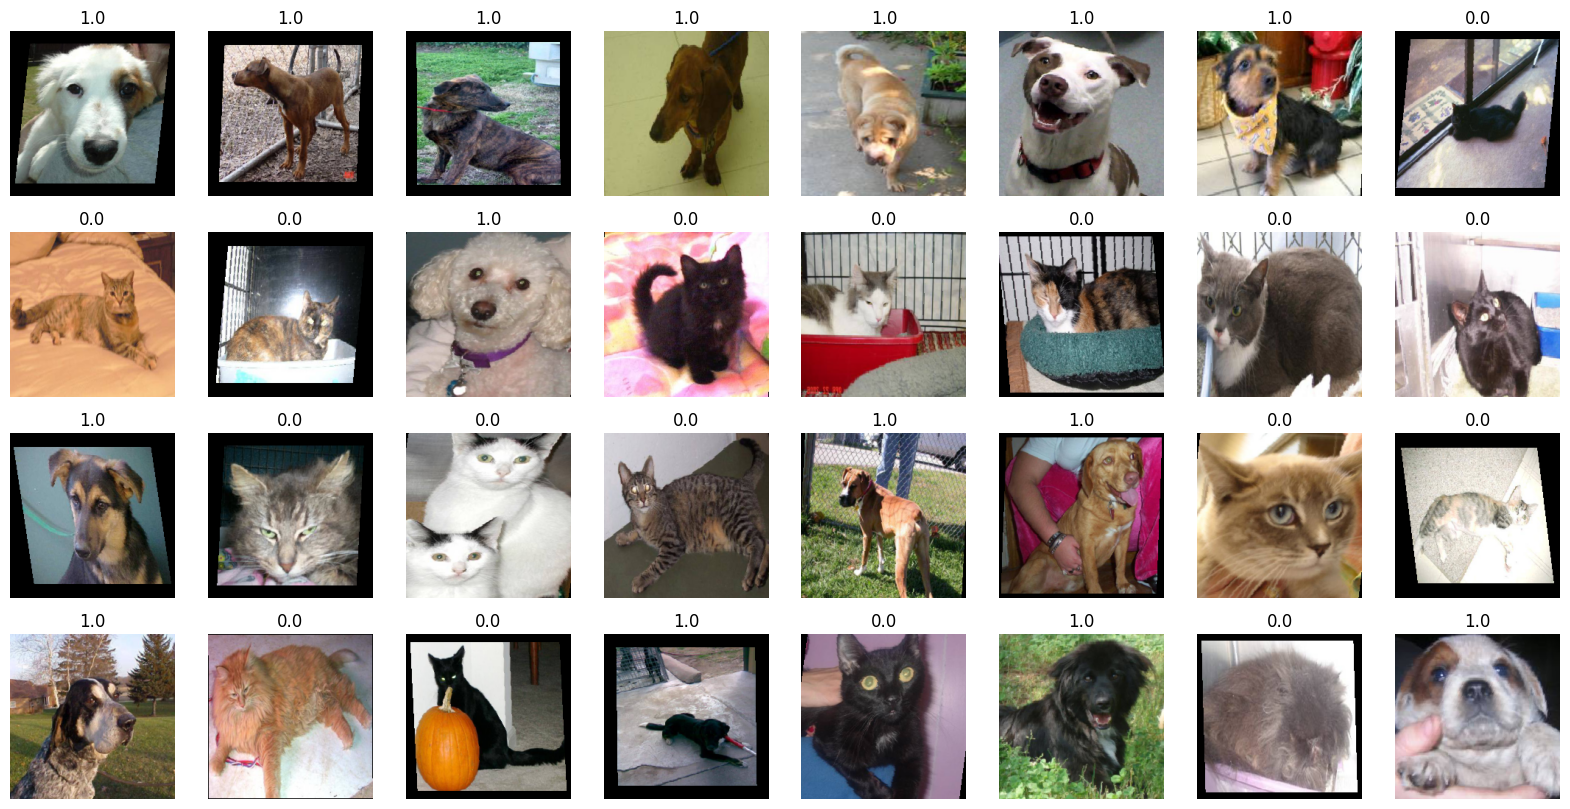

In [22]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize = (20, 10))

for ax, img, label in zip(axes.flatten(), imgs, labels):
  ax.set_title(label.item())
  ax.imshow(img.permute(1, 2, 0))
  ax.axis('off')

In [23]:
# model = models.resnet50(pretrained = True).to(device)
model = models.resnet50(weights='IMAGENET1K_V1').to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
for param in model.parameters():
  param.requires_grad = False # 가져온 파라미터(w, b)를 업데이트 하지 않음

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

epochs = 5

for epoch in range(epochs):
  for phase in ['train', 'validation']:
    if phase == 'trian':
      model.train()
    else:
      model.eval()

    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[phase]:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred =model(x_batch)

      loss = nn.BCELoss()(y_pred, y_batch)

      if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      sum_losses = sum_losses + loss.item()

      y_bool = (y_pred >= 0.5).float()
      acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
      sum_accs = sum_accs + acc.item()

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])

    print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/5, Loss: 0.1929, Accuracy: 95.51%
validation: Epoch    1/5, Loss: 0.0798, Accuracy: 97.87%
train     : Epoch    2/5, Loss: 0.0818, Accuracy: 97.26%
validation: Epoch    2/5, Loss: 0.0628, Accuracy: 97.72%
train     : Epoch    3/5, Loss: 0.0690, Accuracy: 97.45%
validation: Epoch    3/5, Loss: 0.0569, Accuracy: 97.77%
train     : Epoch    4/5, Loss: 0.0633, Accuracy: 97.54%
validation: Epoch    4/5, Loss: 0.0564, Accuracy: 97.92%
train     : Epoch    5/5, Loss: 0.0599, Accuracy: 97.79%
validation: Epoch    5/5, Loss: 0.0525, Accuracy: 98.16%


In [26]:
torch.save(model.state_dict(), 'model.h5')

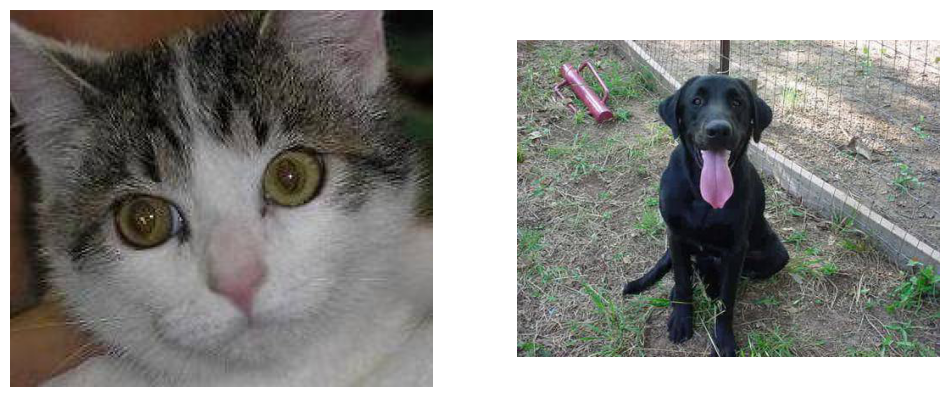

In [42]:
from PIL import Image

img1 = Image.open('test_set/test_set/cats/cat.4061.jpg')
img2 = Image.open('test_set/test_set/dogs/dog.4045.jpg')

fig, axes = plt.subplots(1, 2, figsize = (12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')

plt.show()

In [43]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [44]:
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [45]:
y_pred = model(test_batch)
y_pred

tensor([[4.9929e-05],
        [9.9991e-01]], device='cuda:0', grad_fn=<SigmoidBackward0>)

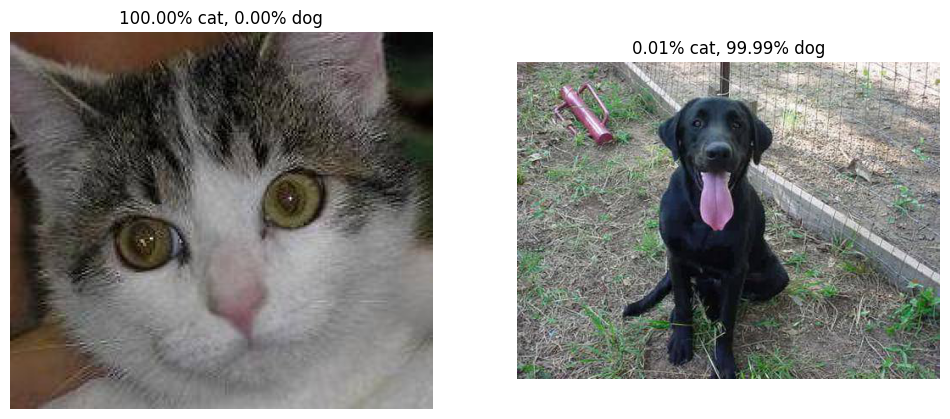

In [46]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

axes[0].set_title(f'{(1-y_pred[0, 0]) * 100:.2f}% cat, {y_pred[0, 0] * 100:.2f}% dog')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1, 0]) * 100:.2f}% cat, {y_pred[1, 0] * 100:.2f}% dog')
axes[1].imshow(img2)
axes[1].axis('off')

plt.show()